# Import

In [1]:
import numpy as np
from scipy.integrate import odeint
import matplotlib.pyplot as plt

import pandas as pd

# Get Data

### Use the World Bank API

In [2]:
# need to install "pip install wbdata"
import wbdata as wb
import datetime

In [3]:
#from world bank API:
wb_indicators = ['SH.DYN.MORT','SH.IMM.MEAS',
                 'NY.GDP.PCAP.CD','SP.DYN.TFRT.IN',
                 'SP.POP.TOTL','PA.NUS.FCRF']
wb_indicator_names = ['CM','M',
                       'G','Fr',
                      'Population','Local2USD']
wb_dict = {indicator:name for indicator,name in zip(wb_indicators,wb_indicator_names)}
wb_dict

{'SH.DYN.MORT': 'CM',
 'SH.IMM.MEAS': 'M',
 'NY.GDP.PCAP.CD': 'G',
 'SP.DYN.TFRT.IN': 'Fr',
 'SP.POP.TOTL': 'Population',
 'PA.NUS.FCRF': 'Local2USD'}

In [4]:
# fetch the data for 1980 - 2020
data_date = (datetime.datetime(1980, 1, 1), datetime.datetime(2020, 1, 1))

wb_data = wb.get_dataframe(wb_dict,country=['ETH','BGD','LAO','TZA'],data_date=data_date).reset_index()
wb_data['date'] = wb_data['date'].astype(int)
wb_data = wb_data.set_index(['country','date'])

wb_data.head()

CM     M            G     Fr   Population  Local2USD
country    date                                                        
Bangladesh 2019   NaN   NaN          NaN    NaN          NaN        NaN
           2018  30.2  97.0  1698.262802    NaN  161356039.0  83.466202
           2017  31.9  97.0  1563.994082  2.062  159670593.0  80.437542
           2016  33.9  97.0  1401.620628  2.090  157970840.0  78.468092
           2015  36.1  97.0  1248.453398  2.120  156256276.0  77.946908

### [Heritage Foundation Data](https://www.heritage.org/index/explore) for the *Trade Freedom* variable

In [5]:
heritage_data = pd.read_csv('data/new/heritage_data_2019.csv')
heritage_data.head()

,name,index year,overall score,property rights,government integrity,judicial effectiveness,tax burden,government spending,fiscal health,business freedom,labor freedom,monetary freedom,trade freedom,investment freedom,financial freedom
0,Afghanistan,2019,51.5,19.6,25.2,29.6,91.7,80.3,99.3,49.2,60.4,76.7,66.0,10.0,10.0
1,Albania,2019,66.5,54.8,40.4,30.6,86.3,73.9,80.6,69.3,52.7,81.5,87.8,70.0,70.0
2,Algeria,2019,46.2,31.6,28.9,36.2,76.4,48.7,18.7,61.6,49.9,74.9,67.4,30.0,30.0
3,Angola,2019,50.6,35.9,20.5,26.6,83.9,80.7,58.2,55.7,58.8,55.4,61.2,30.0,40.0
4,Argentina,2019,52.2,47.8,33.5,44.5,69.3,49.5,33.0,56.4,46.9,60.2,70.0,55.0,60.0


In [6]:
Tf_series = heritage_data[heritage_data['name'].isin(['Ethiopia','Bangladesh','Laos','Tanzania'])
                         ][['name','index year','trade freedom']]

Tf_series['name'] = Tf_series['name'].replace('Laos','Lao PDR')
Tf_series = Tf_series.set_index(['name','index year'])['trade freedom']

Tf_series.head()

name        index year
Bangladesh  2019          63.6
Ethiopia    2019          60.8
Lao PDR     2019          81.8
Tanzania    2019          67.8
Bangladesh  2018          61.2
Name: trade freedom, dtype: float64

### Assemble

In [7]:
df = wb_data.copy()
df.insert(loc=4,column='Tf',value=Tf_series)

df = df.sort_index()

In [8]:
df.head()

CM    M           G     Fr  Tf  Population  Local2USD
country    date                                                          
Bangladesh 1980  198.7  NaN  227.751947  6.359 NaN  79639491.0  15.454058
           1981  194.1  NaN  247.649620  6.217 NaN  81767515.0  17.986692
           1982  189.3  1.0  220.718810  6.058 NaN  83932127.0  22.117883
           1983  184.2  1.0  204.417678  5.884 NaN  86142495.0  24.615425
           1984  178.9  1.0  213.996658  5.698 NaN  88416521.0  25.353933

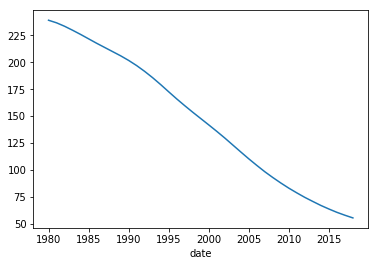

In [9]:
df.loc['Ethiopia']['CM'].plot()
plt.show()

## Check that transformations match the old transformed dataset (SelectVar)

In [10]:
SelecVar = pd.read_csv('data\oxymoron\SelectVar.csv')

In [11]:
df_oxy_wb = SelecVar[
    ['country','year','trade_freedom',]+wb_indicators[:-1]][SelecVar['country'].isin(['Ethiopia','Bangladesh','Lao PDR','Tanzania'])]
df_oxy_wb.columns = ['country','date','Tf'] + wb_indicator_names[:-1]
df_oxy_wb = df_oxy_wb.set_index(['country','date'])

In [12]:
df_oxy_wb[15:20]

Tf     CM     M         G     Fr  Population
country    date                                                
Bangladesh 1995  0.00  11.42  0.79  5.757350  3.732   18.601915
           1996  0.38  10.86  0.69  5.805846  3.596   18.622812
           1997  0.38  10.32  0.72  5.825111  3.468   18.643387
           1998  0.38   9.79  0.71  5.846080  3.346   18.663458
           1999  0.34   9.29  0.71  5.862445  3.231   18.682790

In [13]:
df[['Tf']+wb_indicator_names][15:20]

Tf     CM     M           G     Fr   Population  Local2USD
country    date                                                              
Bangladesh 1995   0.0  113.9  79.0  329.424085  3.713  115169930.0  40.278318
           1996  38.0  108.2  69.0  394.717475  3.591  117649932.0  41.794168
           1997  38.0  102.6  72.0  401.498691  3.478  120160564.0  43.892116
           1998  38.0   97.3  71.0  407.429186  3.371  122682815.0  46.905652
           1999  34.0   92.2  71.0  409.543197  3.269  125189651.0  49.085400

In [14]:
# perform transformations were needed
df_trans = df.copy()

df_trans['CM'] = df['CM']/10
df_trans['M'] = df['M']/100
df_trans['Tf'] = df['Tf']/100
df_trans['G'] = np.log(df['G'])
df_trans['Population'] = np.log(df['Population'])

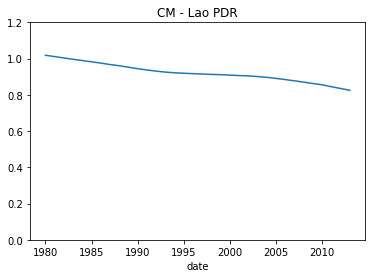

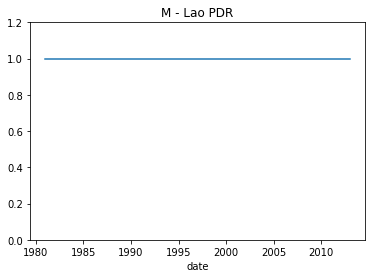

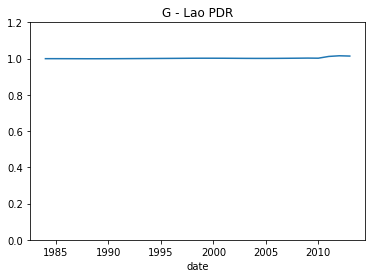

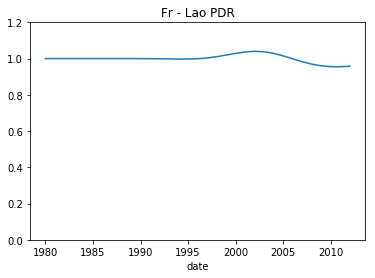

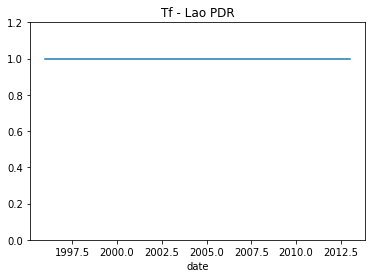

In [15]:
# Plot new transformed data divided by the equivalent old data. Everything should be 1 if equal.

country = 'Lao PDR'
for label in list(df_trans.columns[:-2]):
    
    # get ratio - should be 1 if correct
    (df_trans[label]/df_oxy_wb[label]).loc[country].plot()

    plt.title(label+' - '+ country)
    plt.ylim(0,1.2)
    plt.show()

## The Model from the paper

In [16]:
def CM_change(p_array):
    M,Tf,G,Fr = p_array
    return -0.03*Tf*G + 0.86*M - 6.4*M/G - 0.001*Fr**3

# test
CM_change([1,1,1,1])

-5.571000000000001

## Run

In [17]:
def get_se(preds):
    """Given a two column dataframe of true and predicted values,
    return root mean square errors"""
    
    preds = preds.dropna()
    y = preds.iloc[:,0]
    y_pred = preds.iloc[:,1]
    rmse = np.sqrt(sum((y - y_pred)**2)/len(y))
    
    return rmse

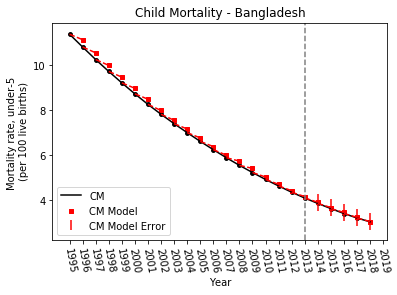

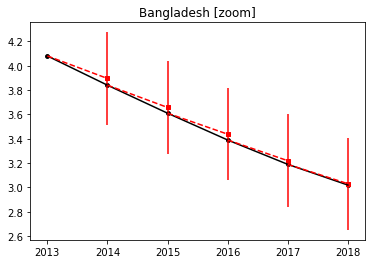

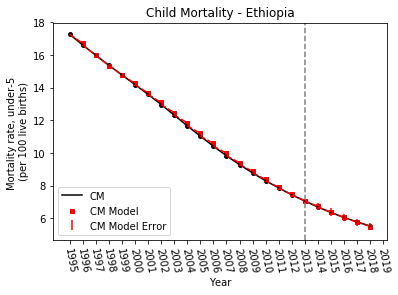

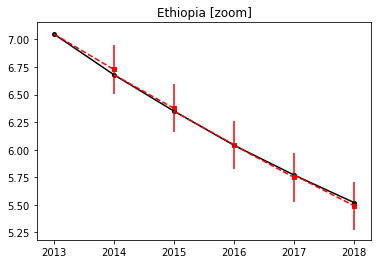

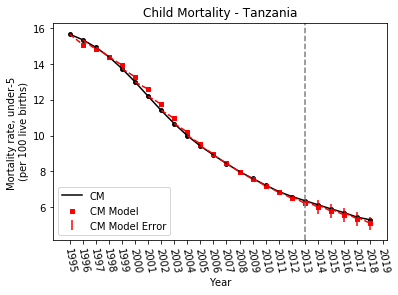

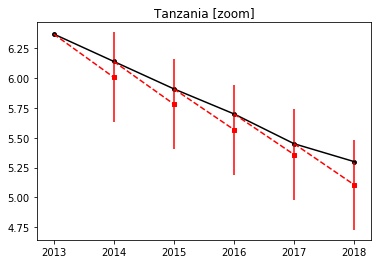

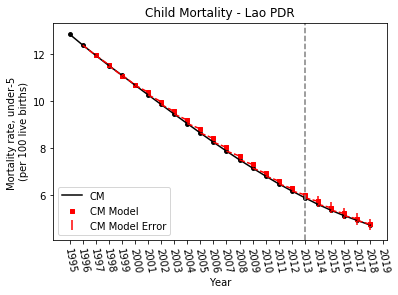

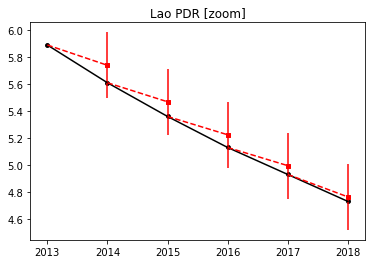

In [18]:
for country in ['Bangladesh','Ethiopia','Tanzania','Lao PDR']:
    
    # create copy of true values as dataframe
    preds = df_trans.loc[country].loc[1995:][['CM']].copy()
    
    # do the predictions and store in the second column of preds
    for year in range(1995,2019):
        p_array = df_trans.loc[country,year][['M','Tf','G','Fr']].values
        CM_next_year = CM_change(p_array) + df_trans.loc[country,year]['CM']
        preds.loc[year+1,'CM Model'] = CM_next_year
    
    # get errors for 2013 onwards based on pre-2013 fit
    se = get_se(preds.loc[:2014])
    
    ## PLOT 1
    
    # a. points
    preds['CM'].plot(color=['k'])
    plt.scatter(preds.index,preds['CM'],c='k',s=15,label='_nolegend_')
    plt.scatter(preds.index,preds['CM Model'],c='r',marker='s',s=15,label='CM Model')
    
    # b. dashed pairwise lines
    for year in list(preds.index)[:-1]:
        plt.plot([year,year+1],[preds['CM'][year],preds['CM Model'][year+1]],'r--')
    
    # c. errorbars
    plt.errorbar(preds.loc[2014:].index,preds.loc[2014:]['CM Model'],yerr=2*se,fmt='none',c='r',label='CM Model Error')
    
    # d. draw vertical line to separate taining and prediction data at 2013
    plt.axvline(x=2013,linestyle='--',color='grey')
    
    # formatting
    plt.legend()
    plt.xticks(range(1995,2020),rotation=280)
    plt.title('Child Mortality - '+country)
    plt.ylabel('Mortality rate, under-5 \n(per 100 live births)')
    plt.xlabel('Year')
    
    # output to file
    plt.savefig('outputs/figs_modelling/model_CM_'+country+'.png',dpi=200)
    plt.show()
    
    
    
    ## PLOT 2 - Zoomed in
    zoom_pred = preds.loc[2013:]
    
    # a. points
    zoom_pred['CM'].plot(color=['k'])
    plt.scatter(zoom_pred.index,zoom_pred['CM'],c='k',s=15,label='_nolegend_')
    plt.scatter(zoom_pred.loc[2014:].index,zoom_pred.loc[2014:]['CM Model'],c='r',marker='s',s=15,label='CM Model')
    
    # b. dashed pairwise lines
    for year in list(zoom_pred.index)[:-1]:
        plt.plot([year,year+1],[zoom_pred['CM'][year],zoom_pred['CM Model'][year+1]],'r--')
    
    # c. errorbars
    plt.errorbar(zoom_pred.loc[2014:].index,zoom_pred.loc[2014:]['CM Model'],yerr=2*se,fmt='none',c='r',label='CM Model Error')
    
    # formatting
    plt.title(country+' [zoom]')
    plt.xticks(range(2013,2019))
    plt.ylabel('')
    plt.xlabel('')
    
    # output to file
    plt.savefig('outputs/figs_modelling/model_CM_'+country+'_zoom.png',dpi=200)
    plt.show()